# Load packages

In [ ]:
import numpy as np
import re
import pandas as pd
from scipy.spatial import distance
import random
import os
import glob

In [ ]:
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, Dropout, BatchNormalization, Input, Lambda, LSTM, RepeatVector, Masking
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets
from tensorflow.keras import backend as K
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data loader

In [ ]:
def read_npy_file(item):
    data = np.load(item.decode())
    return data.astype(np.float32)

In [ ]:
# Training data
train_path = '/content/gdrive/MyDrive/Projet_long/train'
file_list = [os.path.join(train_path, p) for p in sorted(os.listdir(train_path))]

dataset = tf.data.Dataset.from_tensor_slices(file_list[:200])

dataset = dataset.map(lambda item: tuple(tf.numpy_function(read_npy_file, [item], [tf.float32,])))

In [ ]:
# Validation data
val_path = '/content/gdrive/MyDrive/Projet_long/val'
val_file_list = [os.path.join(val_path, p) for p in sorted(os.listdir(val_path))]

val_dataset = tf.data.Dataset.from_tensor_slices(val_file_list)

val_dataset = val_dataset.map(lambda item: tuple(tf.numpy_function(read_npy_file, [item], [tf.float32,])))

In [ ]:
for x in dataset:
    print(x[0].shape)
    break

(10, 256, 1024)


# Model

## Build Model

In [ ]:
latent_dim = 128

In [ ]:
def crop_outputs(x):
  ''' Pass the mask to the output'''
    padding = K.cast(K.not_equal(x[1], 0), dtype=K.floatx())
    return x[0] * padding

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, 128), mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

In [ ]:
# Variational Autoencoder loss
def vae_loss(x, x_decoded_mean, z_log_var, z_mean):
    xent_loss = input_layer.shape[1] * K.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
    vae_loss = K.mean(xent_loss + kl_loss)

    return vae_loss

In [ ]:
#Encoding Layers
input_layer = Input(shape=(256, 1024,))
x = Masking(mask_value=0.)(input_layer)
h = LSTM(256, activation='relu')(x)

#Latent layers
z_mean=Dense(128)(h)
z_log_var=Dense(128)(h)
z = Lambda(sampling, output_shape=(128,))([z_mean, z_log_var])

encoder = keras.Model(input_layer, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1024)]  0           []                               
                                                                                                  
 masking (Masking)              (None, 256, 1024)    0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 256)          1311744     ['masking[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          32896       ['lstm[0][0]']                   
                                                                                            

In [ ]:
# decoded LSTM layer
decoder_input = Input(shape=(128,))

h_decoded = RepeatVector(256)(z)

h_decoded = LSTM(256, return_sequences=True)(h_decoded)

# decoded layer
x_decoded_mean = LSTM(1024, return_sequences=True)(h_decoded)

# Apply the mak
decoded = Lambda(crop_outputs,output_shape=(256,1024))([x_decoded_mean,input_layer])


In [ ]:
# autoencoder
vae = Model(input_layer, decoded)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1024)]  0           []                               
                                                                                                  
 masking (Masking)              (None, 256, 1024)    0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 256)          1311744     ['masking[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          32896       ['lstm[0][0]']                   
                                                                                              

## Plot Model

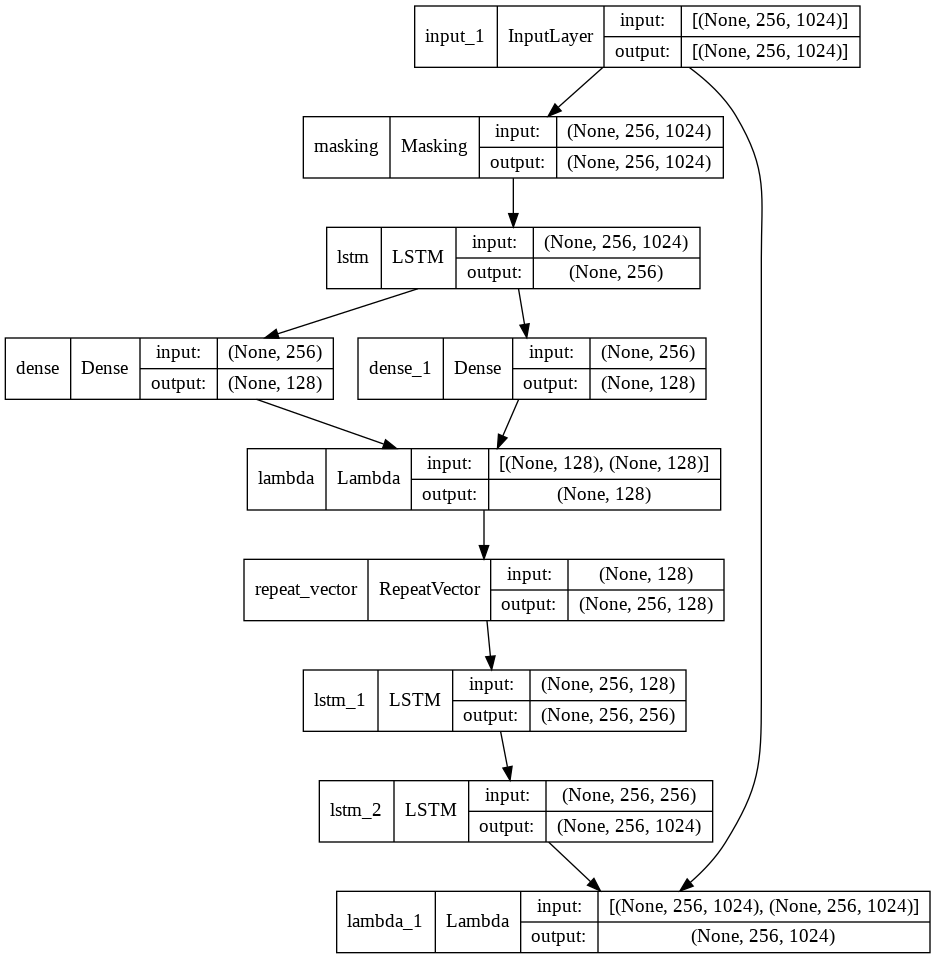

In [ ]:
plot_model(vae, "VAE_128_model.png", show_shapes= True)

## Compile Model

In [ ]:
vae.add_loss(vae_loss(x, x_decoded_mean, z_log_var, z_mean))

In [ ]:
vae.compile(optimizer="adam", loss=None)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(patience=3)

## Training Model

In [ ]:
hist=vae.fit(dataset,
        shuffle=True,
        epochs=50,
        batch_size=1, 
        validation_data=(val_dataset, None),
        callbacks=[callback]  
            ) 

## Save Model

In [ ]:
# Save vae 
vae.save('/content/gdrive/MyDrive/Projet_long/vae128')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projet_long/model3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projet_long/model3/assets


In [ ]:
# Save encoder
encoder.save('/content/gdrive/MyDrive/Projet_long/encoder128')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projet_long/encoder2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projet_long/encoder2/assets
